# **Capstone: Marketing and Retail Analytics**

## *Background and Problem Statement:*
OList, an e-commerce company has faced some losses recently and they want to reduce any unnecessary inventory costs. <br>

To manage the inventory cost of the company OList, it is required to <br> 
- identify top products contributing to the revenue, <br> 
- identify items that are more likely to be purchased individually or in combination with some other products, <br> 
- identify the items in various product categories which they can get rid of without significantly impacting business. <br>

### Disclaimers: <br>
- Only the cases having order status as 'delivered' are considered. <br>
- EDA is performed to treat outliers and missing values carefully before making any inferences from the dataset. <br>

### Important Aspects for Problem Solving:
1. 80-20 Rule of Pareto Analysis: 20% of items sold might be generating 80% revenue.
2. Ideal Category Depth: Category Depth indicates variations of a product the company is offering.
3. Products Sold more than others: Product Combinations sold more often.
4. Reduce Inventory: Bring down number of Items in various Categories not significant for the company.

### Retail Dataset ERD

This is how the various tables in the dataset are associated with each other.

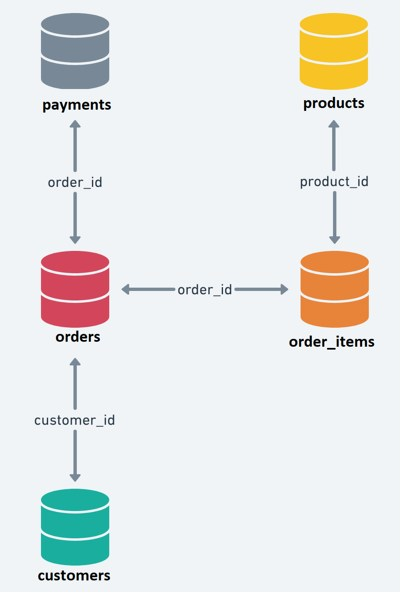

## Import required libraries

In [1]:
# libaries for numerical operations and handling dataframes
import numpy as np, pandas as pd

# libraries to plot various graphs for data analysis
import matplotlib.pyplot as plt, seaborn as sns

# For Market Basket Analysis
from mlxtend.frequent_patterns import apriori, association_rules

## Read the dataset
1. orders
2. order_items
3. customers
4. payments
5. products

### orders

In [2]:
# read orders table from the retail dataset
orders = pd.read_excel('Retail_dataset.xlsx', sheet_name='orders')

In [3]:
# Only the 'delivered' orders need to be considered according to the problem statement
orders = orders[orders.order_status == 'delivered']

In [4]:
# drop order_status column as it is no more relevant, while re-adjusting the index
orders.drop(columns=['order_status'], axis=1, inplace=True)
orders.reset_index(drop=True, inplace=True)

In [5]:
# Look at basic information of orders table
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_purchase_timestamp       96478 non-null  datetime64[ns]
 3   order_approved_at              96464 non-null  datetime64[ns]
 4   order_delivered_timestamp      96470 non-null  datetime64[ns]
 5   order_estimated_delivery_date  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(2)
memory usage: 4.4+ MB


In [6]:
# Observations:
# 1. The order_id and customer_id columns have object datatype which seems correct.
# 2. The timestamp related columns have datetime64[ns] datatype which also seems fine.
# 3. There are two timestamp columns with some null values.

In [7]:
# Look at basic numerical statistics of orders table
# Only numeric columns are datetime columns, and dates statistics is not relevant
# orders.describe()

In [8]:
# Check null values percentage in orders table
(orders.isna().sum() / orders.size) * 100

order_id                         0.000000
customer_id                      0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.002419
order_delivered_timestamp        0.001382
order_estimated_delivery_date    0.000000
dtype: float64

In [9]:
# How many orders are approved before purchase, on same day or later than purchased
print('Orders Approved Before Purchase: ', (orders[orders.order_approved_at.dt.date<orders.order_purchase_timestamp.dt.date]).shape[0])
print('Orders Approved with   Purchase: ', (orders[orders.order_approved_at.dt.date==orders.order_purchase_timestamp.dt.date]).shape[0])
print('Orders Approved After  Purchase: ', (orders[orders.order_approved_at.dt.date>orders.order_purchase_timestamp.dt.date]).shape[0])

Orders Approved Before Purchase:  0
Orders Approved with   Purchase:  66849
Orders Approved After  Purchase:  29615


In [10]:
# Most of the orders were Purchased and Approved on same date
# Null values can be adjusted accordingly.
orders.order_approved_at.fillna(value=orders.order_purchase_timestamp, inplace=True)

In [11]:
# Check null values percentage in orders table
(orders.isna().sum() / orders.size) * 100

order_id                         0.000000
customer_id                      0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.000000
order_delivered_timestamp        0.001382
order_estimated_delivery_date    0.000000
dtype: float64

In [12]:
# Records with missing order_delivered_timestamp
orders[orders.order_delivered_timestamp.isna()]

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
2921,2d1e2d5bf4dc7227b3bfebb81328c15f,13467e882eb3a701826435ee4424f2bd,2017-11-28 17:44:07,2017-11-28 17:56:40,NaT,2017-12-18
20021,f5dd62b788049ad9fc0526e3ad11a097,2f17c5b324ad603491521b279a9ff4de,2018-06-20 06:58:43,2018-06-20 07:19:05,NaT,2018-07-16
42530,2ebdfc4f15f23b91474edf87475f108e,1bd06a0c0df8b23dacfd3725d2dc0bb9,2018-07-01 17:05:11,2018-07-01 17:15:12,NaT,2018-07-30
76909,e69f75a717d64fc5ecdfae42b2e8e086,3bc508d482a402715be4d5cf4020cc81,2018-07-01 22:05:55,2018-07-01 22:15:14,NaT,2018-07-30
80392,0d3268bad9b086af767785e3f0fc0133,ebf7e0d43a78c81991a4c59c145c75db,2018-07-01 21:14:02,2018-07-01 21:29:54,NaT,2018-07-24
89883,2d858f451373b04fb5c984a1cc2defaf,d77cf4be2654aa70ef150f8bfec076a6,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,2017-06-23
94731,ab7c89dc1bf4a1ead9d6ec1ec8968a84,cce5e8188bf42ffb3bb5b18ff58f5965,2018-06-08 12:09:39,2018-06-08 12:36:39,NaT,2018-06-26
95117,20edc82cf5400ce95e1afacc25798b31,175378436e2978be55b8f4316bce4811,2018-06-27 16:09:12,2018-06-27 16:29:30,NaT,2018-07-19


In [13]:
# How many orders were Delivered before, on or after the Estimated date
print('Orders Delivered Before Estimate: ', (orders[orders.order_delivered_timestamp.dt.date<orders.order_estimated_delivery_date.dt.date]).shape[0])
print('Orders Delivered as per Estimate: ', (orders[orders.order_delivered_timestamp.dt.date==orders.order_estimated_delivery_date.dt.date]).shape[0])
print('Orders Delivered After  Estimate: ', (orders[orders.order_delivered_timestamp.dt.date>orders.order_estimated_delivery_date.dt.date]).shape[0])

Orders Delivered Before Estimate:  88644
Orders Delivered as per Estimate:  1292
Orders Delivered After  Estimate:  6534


In [14]:
# How many orders were Delievered at least 1 day prior to the Estimation date
# orders[((orders['order_estimated_delivery_date'] - orders['order_delivered_timestamp']) / np.timedelta64(1, 'D')) >= 1].shape[0]

In [15]:
# Most of the orders were Delivered before Estimated date
# Null values can be adjusted accordingly.
orders.order_delivered_timestamp.fillna(value=orders.order_estimated_delivery_date+pd.DateOffset(days=1), inplace=True)

In [16]:
# Orders Deliever Timestamp null values treated?
orders.iloc[[2921, 20021, 42530, 76909, 80392, 89883, 94731, 95117], [orders.columns.get_loc('order_delivered_timestamp'), orders.columns.get_loc('order_estimated_delivery_date')]]

,order_delivered_timestamp,order_estimated_delivery_date
2921,2017-12-19,2017-12-18
20021,2018-07-17,2018-07-16
42530,2018-07-31,2018-07-30
76909,2018-07-31,2018-07-30
80392,2018-07-25,2018-07-24
89883,2017-06-24,2017-06-23
94731,2018-06-27,2018-06-26
95117,2018-07-20,2018-07-19


In [17]:
# Null values in delievery timestamp columns are treated

In [18]:
# Check null values in orders table, after treating null value records in 2 columns
orders.isna().sum()

order_id                         0
customer_id                      0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
dtype: int64

In [19]:
# check number of records and features in orders table, after treating null values in 2 columns
print('Records: {}\nFeatures: {}'.format(orders.shape[0], orders.shape[1]))

Records: 96478
Features: 6


In [20]:
###############################################################################

### order_items

In [21]:
# read order_items table from the retail dataset
items = pd.read_excel('Retail_dataset.xlsx', sheet_name='order_items')

In [22]:
# Look at basic information of items table
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          112650 non-null  object 
 1   order_item_id     112650 non-null  int64  
 2   product_id        112650 non-null  object 
 3   seller_id         112650 non-null  object 
 4   price             112650 non-null  float64
 5   shipping_charges  112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.2+ MB


In [23]:
# Observations:
# 1. The order_id, product_id and seller_id columns have object datatype which seems correct.
# 2. The order_item_id column has integer datatype which is fine too.
# 3. The price and shipping_charges columns have float datatype which is also correct.
# 4. There are no columns with null values.

In [24]:
# Look at basic numerical statistics of items table
items.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

,order_item_id,price,shipping_charges
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
80%,1.000000,150.000000,23.280000
85%,1.000000,179.990000,26.576500
90%,2.000000,229.800000,34.041000
95%,2.000000,349.900000,45.120000


In [25]:
# Observations:
# 1. There are order IDs with as many as 21 items ordered, which is a possible scenario.
# 2. The shipping_charges is as low as 0, which is a possibility if a seller offers free shipping for some products.
# 3. The price is going as high as 6735, which seems quite high compared to that in upto 99% of the cases.
# 4. The shipping_charges is going as high as 409.68 which is quite high compared to that in upto 99% of the cases.

In [26]:
# Check null values in items table
(items.isna().sum() / items.size) * 100

order_id            0.0
order_item_id       0.0
product_id          0.0
seller_id           0.0
price               0.0
shipping_charges    0.0
dtype: float64

In [27]:
# check number of records and features in order_items table
print('Records: {}\nFeatures: {}'.format(items.shape[0], items.shape[1]))

Records: 112650
Features: 6


In [28]:
###############################################################################

### customers

In [29]:
# read customers table from the retail dataset
customers = pd.read_excel('Retail_dataset.xlsx', sheet_name='customers')

In [30]:
# Look at basic information of customers table
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [31]:
# Observations:
# 1. All datatypes seem correct.
# 2. There is no column with null values.

In [32]:
# Look at basic numerical statistics of customers table
# Only numeric column is 'customer_zip_code_prefix' for which numeric description is not necessary.
# customers.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

In [33]:
# Check null values in customers table
# (customers.isna().sum() / customers.size) * 100

In [34]:
# check number of records and features in customers table, after duplicates treatment
print('Records: {}\nFeatures: {}'.format(customers.shape[0], customers.shape[1]))

Records: 99441
Features: 4


In [35]:
###############################################################################

### payments

In [36]:
# read payments table from the retail dataset
payments = pd.read_excel('Retail_dataset.xlsx', sheet_name='payments')

In [37]:
# Look at basic information of payments table
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [38]:
# Observations:
# 1. All datatypes seem correct.
# 2. There is no column with null values.

In [39]:
# Look at basic numerical statistics of payments table
# There is no relevance to look at numeric description of payment_sequential and payment_installments columns.
payments.payment_value.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999])

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
50%         100.000000
75%         171.837500
80%         196.360000
85%         231.120000
90%         297.270000
95%         437.635000
99%        1039.916500
99.5%      1410.275750
99.9%      2339.233250
max       13664.080000
Name: payment_value, dtype: float64

In [40]:
# Observations:
# 1. There are some orders with payment_value 0, which doesn't seem right.
# 2. The highest payment_value is greater than 13000 where as 99.9% of orders have payment_value within 2340.
# 3. The payment_value could go high with the number of items in an order.

In [41]:
# Check null values in payments table
# (payments.isna().sum() / payments.size) * 100

In [42]:
# check number of records and features in payments table
print('Records: {}\nFeatures: {}'.format(payments.shape[0], payments.shape[1]))

Records: 103886
Features: 5


In [43]:
###############################################################################

### products

In [44]:
# read products table from the retail dataset
products = pd.read_excel('Retail_dataset.xlsx', sheet_name='products')

In [45]:
# Look at basic information of products table
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32781 non-null  object 
 2   product_weight_g       32949 non-null  float64
 3   product_length_cm      32949 non-null  float64
 4   product_height_cm      32949 non-null  float64
 5   product_width_cm       32949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [46]:
# Observations:
# 1. All datatypes are fine.
# 2. Most of the columns have some or more null values.

In [47]:
# Look at basic numerical statistics of products table
products.describe(percentiles=[0.01, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999])

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32949.000000,32949.000000,32949.000000,32949.000000
mean,2276.472488,30.815078,16.937661,23.196728
std,4282.038731,16.914458,13.637554,12.079047
min,0.000000,7.000000,2.000000,6.000000
1%,60.000000,16.000000,2.000000,11.000000
25%,300.000000,18.000000,8.000000,15.000000
50%,700.000000,25.000000,13.000000,20.000000
75%,1900.000000,38.000000,21.000000,30.000000
80%,2500.000000,41.000000,25.000000,32.000000
85%,3800.000000,46.000000,29.000000,35.000000


In [48]:
# Observations:
# 1. The numeric distributions in columns product_length_cm, product_height_cm and product_width_cm seem fine.
# 2. There are cases with 0 product_weight_g which doesn't seem right.

In [49]:
# Check percentage null values in products table
(products.isna().sum() / products.size) * 100

product_id               0.000000
product_category_name    0.085986
product_weight_g         0.001012
product_length_cm        0.001012
product_height_cm        0.001012
product_width_cm         0.001012
dtype: float64

In [50]:
# Observations:
# 1. Most of the missing values are in product_category_name column and that's approx 8.6%.
# 2. In columns related to product dimensions and weight have very low number of missing values.

In [51]:
# Check null values in products table
products.isna().sum()

product_id                 0
product_category_name    170
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64

In [52]:
# Check null values in column product_weight_g
products[products.product_weight_g.isna()]

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,toys,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,toys,NaN,NaN,NaN,NaN


In [53]:
# Observations:
# 1. There are 2 orders where product dimensions as well as weight values are missing.

In [54]:
# The only 2 missing value records w.r.t product dimension and weight can be dropped
# Dropping the specific index records
products.drop(products.index[[8578, 18851]], inplace=True)

In [55]:
# Check null values in products table
(products.isna().sum() / products.size) * 100

product_id               0.000000
product_category_name    0.085991
product_weight_g         0.000000
product_length_cm        0.000000
product_height_cm        0.000000
product_width_cm         0.000000
dtype: float64

In [56]:
# replace the missing values with a category 'Unknown' in column product_category_name
products.product_category_name.fillna('Unknown', inplace=True)

C:\Users\Umang Malhotra\AppData\Local\Temp\ipykernel_24732\3362810500.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products.product_category_name.fillna('Unknown', inplace=True)


In [57]:
# Check null values in products table, after treating null value records
products.isna().sum()

product_id               0
product_category_name    0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64

In [58]:
# check number of records and features in products table, after treating null values
print('Records: {}\nFeatures: {}'.format(products.shape[0], products.shape[1]))

Records: 32949
Features: 6


In [59]:
###############################################################################

## Merge all the tables to make one data table   

In [60]:
# Merge all the tables
retail = (items
          .merge(orders,    on='order_id',    how='inner')
          .merge(products,  on='product_id',  how='inner')
          .merge(customers, on='customer_id', how='inner')
          .merge(payments,  on='order_id',    how='inner'))

In [61]:
# price + shipping_cgarges make the whole revenue
retail['revenue'] = retail.price + retail.shipping_charges

In [62]:
# Check the features present in the merged data
retail.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id', 'price',
       'shipping_charges', 'customer_id', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_timestamp',
       'order_estimated_delivery_date', 'product_category_name',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'revenue'],
      dtype='object')

In [63]:
# Keep only relevant features for the analysis based on the problem statement
retail = retail[['order_id',
                 'seller_id',
                 'customer_id',
                 'product_id',
                 'order_purchase_timestamp',
                 'product_category_name',
                 'price',
                 'shipping_charges',
                 'revenue']]

retail.head(2)

,order_id,seller_id,customer_id,product_id,order_purchase_timestamp,product_category_name,price,shipping_charges,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,toys,58.9,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,toys,239.9,19.93,259.83


In [64]:
# Check null values in retail table
retail.isna().sum()

order_id                    0
seller_id                   0
customer_id                 0
product_id                  0
order_purchase_timestamp    0
product_category_name       0
price                       0
shipping_charges            0
revenue                     0
dtype: int64

In [65]:
# Check number of duplicate records
retail[retail.duplicated()].shape[0]

24627

In [66]:
# Remove duplicates from the data
retail.drop_duplicates(inplace=True)
retail.reset_index(drop=True, inplace=True)

In [67]:
# Look at basic information of retail table
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100179 entries, 0 to 100178
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  100179 non-null  object        
 1   seller_id                 100179 non-null  object        
 2   customer_id               100179 non-null  object        
 3   product_id                100179 non-null  object        
 4   order_purchase_timestamp  100179 non-null  datetime64[ns]
 5   product_category_name     100179 non-null  object        
 6   price                     100179 non-null  float64       
 7   shipping_charges          100179 non-null  float64       
 8   revenue                   100179 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 6.9+ MB


In [68]:
# The datatypes are fine.
# There are no null values in any column.

In [69]:
# Look at basic numerical statistics of relevant columns in retail table
retail.describe(include=['int64', 'float64'], percentiles=[0.75, 0.95, 0.99, 0.995])

,price,shipping_charges,revenue
count,100179.000000,100179.000000,100179.000000
mean,123.747986,20.070022,143.818008
std,187.579921,15.781827,194.709545
min,0.850000,0.000000,6.080000
50%,78.000000,16.320000,94.960000
75%,139.000000,21.190000,161.335000
95%,355.900000,45.300000,388.250000
99%,899.000000,84.580000,957.209400
99.5%,1250.990000,106.318800,1321.185900
max,6735.000000,409.680000,6929.310000


In [70]:
# price, shipping_charges and therefore revenue show some extreme values beyond their 99th percentiles.
# However, all the records might be valid and useful in the analysis.

In [71]:
# check number of records and features in retail table
print('Records: {}\nFeatures: {}'.format(retail.shape[0], retail.shape[1]))

Records: 100179
Features: 9


In [72]:
#################################################################################

## EDA Key Aspects:
1. 80-20 Rule of Pareto Analysis: Top 20% categories driving ~80% revenue.
2. Ideal Category Depth: Unique SKUs (Stock Keeping Units) per category.
3. Products Sold more than others: Associations of products frequently bought together.
4. Reduce Inventory: Categories with low revenue contribution but high SKU variety (inventory inefficiency).

### 80-20 Rule of Pareto Analysis

In [73]:
# Total revenue by product category
catRevenue = (retail.groupby('product_category_name')['revenue']
                    .sum()
                    .sort_values(ascending=False)
                    .reset_index())

# Cumulative contribution in revenue by product category
catRevenue['cum_revenue'] = catRevenue['revenue'].cumsum()
catRevenue['cum_perc'] = 100 * catRevenue['cum_revenue'] / catRevenue['revenue'].sum()
catRevenue[catRevenue.revenue>100000]

# Product categiories contributing to ~80% of revenue
# catPareto = catRevenue[catRevenue['cum_perc'] <= 81]

# print("Pareto Categories (Top ~20% driving ~80% revenue):")
# catPareto

,product_category_name,revenue,cum_revenue,cum_perc
0,toys,10924105.19,10924105.19,75.822118
1,health_beauty,339192.82,11263298.01,78.176391
2,watches_gifts,293636.86,11556934.87,80.214468
3,sports_leisure,264223.59,11821158.46,82.048393
4,bed_bath_table,260372.94,12081531.40,83.855592
5,computers_accessories,247414.78,12328946.18,85.572850
6,cool_stuff,209106.33,12538052.51,87.024217
7,furniture_decor,199403.97,12737456.48,88.408242
8,housewares,174889.81,12912346.29,89.622118
9,auto,157109.68,13069455.97,90.712586


In [74]:
# Product Categories which are contributing to the revenue by at least 100,000 are ...
# contributing to the commulative revenue by nearly 93%

### Ideal Category Depth

In [75]:
# Count distinct SKUs per category
catDepth = (retail.groupby('product_category_name')['product_id']
                    .nunique()
                    .sort_values(ascending=False)
                    .reset_index(name='uniqueSKUs'))

print("Category Depth (Unique SKUs per category):")
catDepth[catDepth.uniqueSKUs>100]

Category Depth (Unique SKUs per category):


,product_category_name,uniqueSKUs
0,toys,24187
1,bed_bath_table,781
2,sports_leisure,710
3,furniture_decor,668
4,health_beauty,630
5,housewares,614
6,auto,474
7,computers_accessories,411
8,watches_gifts,330
9,telephony,282


In [76]:
# Top 20 Product Categories in terms of SKUs have minimum 100 SKUs.
# SKUs are going as high as 24187 in 'toys' category
# Other than 'toys' category, the SKUs for top 20 categories have SKUs between 100 to 800.

### Products Sold more than others

In [77]:
# Prepare basket (orders × categories)
ordCatBasket = (retail.groupby(['order_id','product_category_name'])['product_id']
                        .count()
                        .unstack()
                        .fillna(0))

# Convert to binary (0/1)
ordCatBasket = ordCatBasket.applymap(lambda x: 1 if x > 0 else 0)
# Keep categories ordered >5 times
ordCatBasket = ordCatBasket.loc[:, ordCatBasket.sum()>5]
ordCatBasket = ordCatBasket.astype(bool)
# ordCatBasket

C:\Users\Umang Malhotra\AppData\Local\Temp\ipykernel_24732\1578557352.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ordCatBasket = ordCatBasket.applymap(lambda x: 1 if x > 0 else 0)


In [78]:
# Apply Apriori
freqItemSets = apriori(ordCatBasket, min_support=0.01, use_colnames=True)
freqItemSets.sort_values(by='support', ascending=False, inplace=True, ignore_index=True)
freqItemSets

,support,itemsets
0,0.756181,(toys)
1,0.028934,(health_beauty)
2,0.023999,(bed_bath_table)
3,0.021107,(sports_leisure)
4,0.019562,(computers_accessories)
5,0.017841,(furniture_decor)
6,0.015187,(watches_gifts)
7,0.014928,(housewares)
8,0.011124,(telephony)
9,0.010253,(auto)


In [79]:
# Association rules
rules = association_rules(freqItemSets, metric="lift", min_threshold=-1)
rules.sort_values(by='lift', ascending=False, inplace=True, ignore_index=True)
rules

print("Top Product Combinations Frequently Bought Together:")
rules[['antecedents','consequents','support','confidence','lift']].head(10)

Top Product Combinations Frequently Bought Together:


,antecedents,consequents,support,confidence,lift


In [80]:
# With a support threshold as 0.01, there are only 10 frequently ordered itemsets.
# All these itemsets have only 1 item each.
# In the end, there are no associations found between different items.

In [81]:
# Apply Apriori
freqItemSets = apriori(ordCatBasket, min_support=0.0009, use_colnames=True)
freqItemSets.sort_values(by='support', ascending=False, inplace=True, ignore_index=True)
freqItemSets

,support,itemsets
0,0.756181,(toys)
1,0.028934,(health_beauty)
2,0.023999,(bed_bath_table)
3,0.021107,(sports_leisure)
4,0.019562,(computers_accessories)
5,0.017841,(furniture_decor)
6,0.015187,(watches_gifts)
7,0.014928,(housewares)
8,0.011124,(telephony)
9,0.010253,(auto)


In [82]:
# Association rules
rules = association_rules(freqItemSets, metric="lift", min_threshold=-1)
rules.sort_values(by='lift', ascending=False, inplace=True, ignore_index=True)
rules

print("Top Product Combinations Frequently Bought Together:")
rules[['antecedents','consequents','support','confidence','lift']].head(10)

Top Product Combinations Frequently Bought Together:


,antecedents,consequents,support,confidence,lift
0,(toys),(bed_bath_table),0.003017,0.003989,0.166233
1,(bed_bath_table),(toys),0.003017,0.125702,0.166233
2,(toys),(furniture_decor),0.001586,0.002098,0.117567
3,(furniture_decor),(toys),0.001586,0.088902,0.117567
4,(computers_accessories),(toys),0.001068,0.054584,0.072184
5,(toys),(computers_accessories),0.001068,0.001412,0.072184


In [83]:
# With a support threshold as low as 0.0009, there are 34 frequently ordered itemsets.
# Only 2 itemsets [(toys, furniture_decor) and (toys, computers_accessories)] have 2 items each.
# In the end, there are a few associations found.
# However, highest support, confidence and lift are approximately 0.003, 0.004 and 0.166 respectively.

### Reduce Inventory

In [84]:
# Revenue contribution by category
catContrib = (retail.groupby('product_category_name')['revenue']
                                .sum()
                                .reset_index(name='total_revenue_per_category'))

# Category depth (unique SKUs)
catDepth = (retail.groupby('product_category_name')['product_id']
                    .nunique()
                    .sort_values(ascending=False)
                    .reset_index(name='uniqueSKUs'))

# Merge both
catEvaluation = pd.merge(catContrib, catDepth, on='product_category_name')

# Revenue per SKU → efficiency measure
catEvaluation['revenue_per_sku'] = catEvaluation['total_revenue_per_category'] / catEvaluation['uniqueSKUs']

# Low-revenue, high-SKU categories (inefficient inventory)
lowValueCats = catEvaluation[
                (catEvaluation['total_revenue_per_category'] < catEvaluation['total_revenue_per_category'].median()) &
                (catEvaluation['uniqueSKUs'] > catEvaluation['uniqueSKUs'].median())]

print("Categories recommended for reduction (low revenue, high SKU count):")
lowValueCats

Categories recommended for reduction (low revenue, high SKU count):


,product_category_name,total_revenue_per_category,uniqueSKUs,revenue_per_sku
11,books_technical,7304.58,33,221.350909
31,fashion_shoes,6394.29,47,136.048723
62,signaling_and_security,4356.80,30,145.226667


In [85]:
# Categories such as books_technical, fashion_shoes etc contribute low revenue than median revenue across categories.
# Number of SKUs in these categories are higher than median number of SKUs across categories.
# Such SKUs in the mentioned categories are the potential candidates for reduction in OList's inventory.

In [86]:
########################################################################

## Export cleaned/preprocessed dataset for Tableau Visualization & Dashboarding

In [87]:
retail.to_excel(excel_writer='retail_preprocessed.xlsx', sheet_name='Cleaned_Table', freeze_panes=(1,1), index=False)

In [90]:
rules[['antecedents','consequents','support','confidence','lift']].to_excel(excel_writer="Market_Basket_Analysis_Rules.xlsx", index=False)

In [88]:
########################################################################